# Analiza najpopularniejszych tematów chrześcijaństwa
W tym rozdziale zadamy pytanie: jakie tematy są popularne wśród chrześcijan i jakie mogą być przyczyny tej popularności. Popularność będziemy definiować jako sumę UpVote'ów dla postów i odpowiedzi na nich z danym tag'iem.

Najpierw ładujemy wszystkie potrzebne pakiety

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import awoc
from core import DataLoader

Dalej ładujemy dane z serwisu "Christianity.StackExchange"

In [4]:
Christianity = DataLoader('../data/christianity')

Dalej konstruujemy zbiór danych do analizy. Najpierw chcemy policzyć liczbę UpVote'ów dla każdego postu

In [ ]:
upvotes = Christianity._votes_df.loc[Christianity._votes_df['VoteTypeId'] == 2, ['Id', 'PostId']].groupby('PostId').count()

Dla ułatwienia policzymy też sumę UpVote'ów dla odpowiedzi pod danym postem

In [ ]:
posts_with_upvote_count = pd.merge(Christianity._posts_df, upvotes, left_on='Id', right_on='PostId')
answers_with_upvote_count = posts_with_upvote_count.loc[posts_with_upvote_count['PostTypeId'] == 2, ['ParentId', 'Id_y']]\
  .groupby('ParentId').sum()

Tutaj wyznaczmy tag'i dla postów-zapytań, które mają authora

In [ ]:
posts_with_tags = Christianity._posts_df.loc[Christianity._posts_df['PostTypeId'] == 1, ['Id', 'OwnerUserId', 'Tags']]\
  .dropna(subset=['OwnerUserId'], inplace=False)

Teraz robimy join dla tabeli z tag'ami i dwóch tabeli z UpVote'ami i otrzymujemy posty z tag'ami i UpVote'ami dla nich

In [ ]:
posts_with_tags_and_upvotes = pd.merge(posts_with_tags, upvotes, left_on='Id', right_on='PostId')
posts_with_tags_and_upvotes = pd.merge(posts_with_tags_and_upvotes, answers_with_upvote_count, left_on='Id_x', right_on='ParentId')
posts_with_tags_and_upvotes['UpVotes'] = posts_with_tags_and_upvotes['Id_y_x'] + posts_with_tags_and_upvotes['Id_y_y']
posts_with_tags_and_upvotes = posts_with_tags_and_upvotes[['Id_x', 'OwnerUserId', 'UpVotes', 'Tags']]\
  .convert_dtypes()

Teraz dołączmy do tych postów ich author, żeby wyznaczyć "lokalizację" postu

In [ ]:
posts_with_tags_and_upvotes = pd.merge(posts_with_tags_and_upvotes, Christianity._users_df, left_on='OwnerUserId', right_on='Id')[['Location', 'UpVotes_x', 'Tags']]\
  .dropna(subset=['Location'], inplace=False)

Stworzymy słowniki dla każdego regionu, w których kluczem będzie tag, a wartość - jego popularnością

In [ ]:
tag_count_europe = {}
tag_count_north_america = {}
tag_count_south_america = {}
tag_count_asia = {}
tag_count_africa = {}

Czy należy post do danego regionu, będziemy wyznaczać za pomocą lokalizacji jego autora. Dla list krajów dla regionów wykorzystamy pakiet [`awoc`]

In [ ]:

world = awoc.AWOC()
for index, post in posts_with_tags_and_upvotes.iterrows():
  if any(map(post['Location'].__contains__, world.get_countries_list_of('North America'))):
    for tag in post['Tags'].replace('>', ' ').replace('<', ' ').split():
      tag_count_north_america[tag] = tag_count_north_america.get(tag, 0) + post['UpVotes_x']
    continue
  if any(map(post['Location'].__contains__, world.get_countries_list_of('Europe'))):
    for tag in post.loc['Tags'].replace('>', ' ').replace('<', ' ').split():
      tag_count_europe[tag] = tag_count_europe.get(tag, 0) + post['UpVotes_x']
    continue
  if any(map(post['Location'].__contains__, world.get_countries_list_of('South America'))):
    for tag in post.loc['Tags'].replace('>', ' ').replace('<', ' ').split():
      tag_count_south_america[tag] = tag_count_south_america.get(tag, 0) + post['UpVotes_x']
    continue
  if any(map(post['Location'].__contains__, world.get_countries_list_of('Asia'))):
    for tag in post.loc['Tags'].replace('>', ' ').replace('<', ' ').split():
      tag_count_asia[tag] = tag_count_asia.get(tag, 0) + post['UpVotes_x']
    continue
  if any(map(post['Location'].__contains__, world.get_countries_list_of('Africa'))):
    for tag in post.loc['Tags'].replace('>', ' ').replace('<', ' ').split():
      tag_count_africa[tag] = tag_count_africa.get(tag, 0) + post['UpVotes_x']

Teraz połączymy uzyskane wyniki w jedną tabelę, w którym rekordem będzie tag i jego popularność w każdym regionie

In [7]:
tag_count_by_location = pd.DataFrame({'TagName': tag_count_europe.keys(), 'CountInEurope': tag_count_europe.values()})
tag_count_by_location = pd.merge(tag_count_by_location, pd.DataFrame({'TagName': tag_count_south_america.keys(), 'CountInSouthAmerica': tag_count_south_america.values()}), how='outer')
tag_count_by_location = pd.merge(tag_count_by_location, pd.DataFrame({'TagName': tag_count_asia.keys(), 'CountInAsia': tag_count_asia.values()}), how='outer')
tag_count_by_location = pd.merge(tag_count_by_location, pd.DataFrame({'TagName': tag_count_africa.keys(), 'CountInAfrica': tag_count_africa.values()}), how='outer')
tag_count_by_location = pd.merge(tag_count_by_location, pd.DataFrame({'TagName': tag_count_north_america.keys(), 'CountInNorthAmerica': tag_count_north_america.values()}), how='outer')\
  .fillna(0)\
  .convert_dtypes()

Narysujmy wykres najbardziej popularnych tag'ów dla każdego regionu

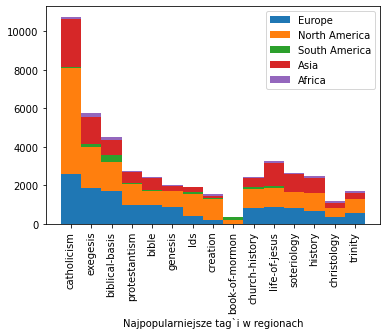

In [23]:
bar_width = 1
tag_count = 6
top_tag_count_in_europe = tag_count_by_location.sort_values(by='CountInEurope', ascending=False).head(tag_count)
top_tag_count_in_north_america = tag_count_by_location.sort_values(by='CountInNorthAmerica', ascending=False).head(tag_count)
top_tag_count_in_south_america = tag_count_by_location.sort_values(by='CountInSouthAmerica', ascending=False).head(tag_count)
top_tag_count_in_africa = tag_count_by_location.sort_values(by='CountInAfrica', ascending=False).head(tag_count)
top_tag_count_in_asia = tag_count_by_location.sort_values(by='CountInAsia', ascending=False).head(tag_count)
top_tag_count_by_location = pd.merge(top_tag_count_in_europe, top_tag_count_in_north_america, how='outer')
top_tag_count_by_location = pd.merge(top_tag_count_by_location, top_tag_count_in_south_america, how='outer')
top_tag_count_by_location = pd.merge(top_tag_count_by_location, top_tag_count_in_asia, how='outer')
top_tag_count_by_location = pd.merge(top_tag_count_by_location, top_tag_count_in_africa, how='outer').fillna(0)
r = range(0, len(top_tag_count_by_location))
bottom1 = top_tag_count_by_location['CountInEurope']
bottom2 = bottom1 + top_tag_count_by_location['CountInNorthAmerica']
bottom3 = bottom2 + top_tag_count_by_location['CountInSouthAmerica']
bottom4 = bottom3 + top_tag_count_by_location['CountInAsia']
plt.bar(r, top_tag_count_by_location['CountInEurope'], width=bar_width, label='Europe')
plt.bar(r, top_tag_count_by_location['CountInNorthAmerica'], bottom=bottom1, width=bar_width, label='North America')
plt.bar(r, top_tag_count_by_location['CountInSouthAmerica'], bottom=bottom2, width=bar_width, label='South America')
plt.bar(r, top_tag_count_by_location['CountInAsia'], bottom=bottom3, width=bar_width, label='Asia')
plt.bar(r, top_tag_count_by_location['CountInAfrica'], bottom=bottom4, width=bar_width, label='Africa')
plt.xlabel('Najpopularniejsze tag`i w regionach')
plt.xticks(r, top_tag_count_by_location['TagName'], rotation='vertical')
plt.legend()
plt.show()

Z powyższego wykresu możemy wywnioskować kilka rzeczy:
1. W Azji jest wiele katolików czy też ciekawskich - исторически так сложилось, объяснить
2. Мормоны встечаются чаще всего в Америках
3. В Африку почти не завезли христианство и сервисы
4. Тоже самое как 2 только для lbs
5. Европейцы больше интересуются библией - объяснить
6. Сказать, что зная, что в Америке очень развиты подобные сервисы (наверное), то\
3.1 Протестантизм чаще встечается в Европе - логично
3.2 Европейцы больше интересуются историей церкви, чем остальные - древнее
